# CO2 Forecasting with SARIMAX Model

This notebook demonstrates how to forecast CO2 levels using a SARIMAX model with exogenous variables. The workflow includes data preprocessing, model training, forecasting, and comparison of forecasted values with actual data.

## Setup
First, we install the necessary librairies.



In [1]:
!pip install pmdarima


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Import Libraries
We import essential libraries including pandas for data manipulation, matplotlib for plotting, statsmodels for statistical modeling, and others.


In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import pmdarima as pm
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualizing data
We load the dataset from a CSV file, ensure the index is datetime, and handle any NaN or infinite values to clean the data.


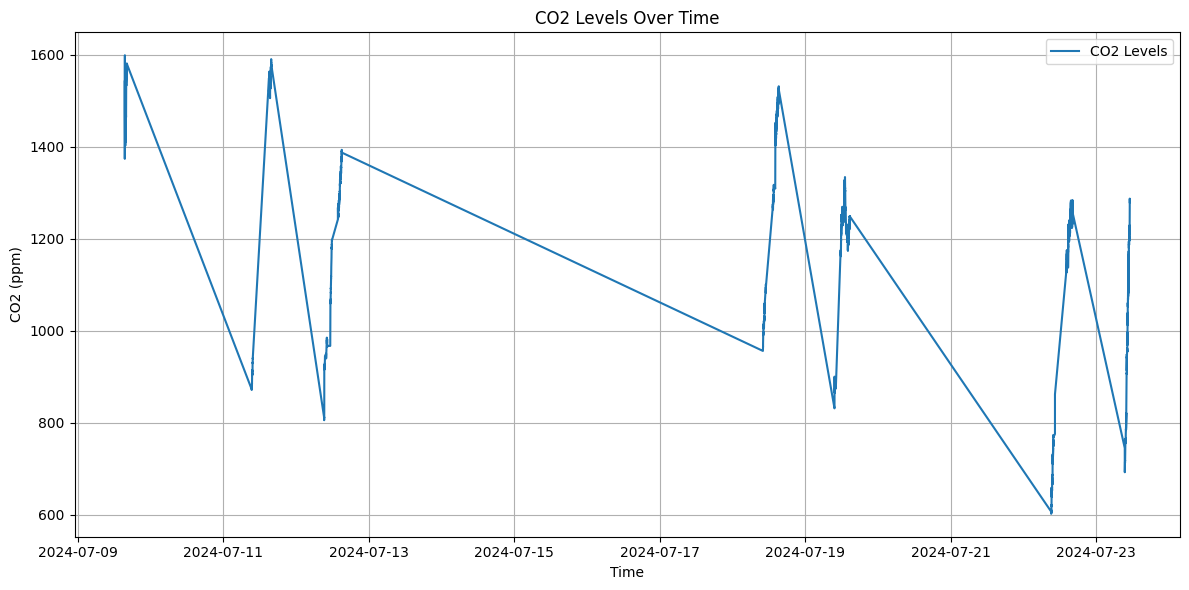

In [3]:
#Preparing data
df = pd.read_csv('labeled_sensor_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Ensure the index is datetime
df.index = pd.to_datetime(df.index)

# Check for and handle any remaining NaNs or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['CO2 (ppm)'], label='CO2 Levels')
plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.title('CO2 Levels Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Test for Stationarity

Before building the forecasting model, it's essential to test if the data is stationary. Stationary data have constant mean, variance, and autocorrelation over time, which is a key assumption for many time series models. We use the Augmented Dickey-Fuller (ADF) test to check for stationarity.


In [4]:
#Testing if the time series data is stationary.
result = adfuller(df['CO2 (ppm)'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}') #The p-value needs to be below 0.05.
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.987990419751213
n_lags: 0.001474719087320788
p-value: 0.001474719087320788
Critial Values:
   1%, -3.4306357781798216
Critial Values:
   5%, -2.8616663047886597
Critial Values:
   10%, -2.5668372284354013


# Train the SARIMAX Model

Using the `auto_arima` function, we find the best model parameters with exogenous variables and then fit the SARIMAX model on the training data.


In [10]:
# Specify the day for which you want to make predictions
specific_day = '2024-07-23'  # Replace with your desired date

# Filter data for the specific day
df_day = df[df.index.date == pd.to_datetime(specific_day).date()]

# Define split point for training and test sets
split_date = df.index[-int(0.01*len(df))]  # 95% for training, 5% for testing

# Split the data into training and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Define the exogenous variables
exogenous_variables = ['Temperature (�C)', 'Humidity (%)', 'DayOfWeek', 'CO2_lag1', 'Temp_lag1', 'Hum_lag1', 'Occupancy']

# Ensure the exogenous variables are properly aligned
train_exog = train_data[exogenous_variables]
test_exog = test_data[exogenous_variables]

# Use auto_arima to find the best model parameters with exogenous variables
stepwise_model = auto_arima(train_data['CO2 (ppm)'],
                            exogenous=train_exog,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=True,
                            d=0,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Print the best model parameters
print(stepwise_model.summary())

# Fit the best SARIMAX model on the training data with exogenous variables
sarimax_results = sm.tsa.SARIMAX(train_data['CO2 (ppm)'],
                                 exog=train_exog,
                                 order=stepwise_model.order,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit()

# Print the summary of the model
print(sarimax_results.summary())

# Forecast future values with exogenous variables for the specific day
forecast_steps = 20  # Forecasting for the next 20 minutes
forecast_index = pd.date_range(start=df_day.index[-1] + pd.Timedelta(minutes=1),
                                periods=forecast_steps,
                                freq='min')
test_exog_day = df_day[exogenous_variables].iloc[-forecast_steps:]
forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=test_exog_day)

# Extract forecasted values and associated confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("Forecast Index:")
print(forecast_index)

print("\nForecast Mean:")
print(forecast_mean)

print("\nForecast Confidence Intervals:")
print(forecast_ci)

# Save the forecasted values to a CSV file
forecast_df = pd.DataFrame({
    'Timestamp': forecast_index,
    'Forecast': forecast_mean
})
forecast_df.to_csv('forecast_predictions.csv', index=False)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=175602.211, Time=3.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=310655.618, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=280861.362, Time=4.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=385977.460, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=175603.963, Time=5.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=175603.773, Time=5.62 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=256894.570, Time=16.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=175605.680, Time=24.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=175618.136, Time=1.38 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 67.365 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                22658
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -85281.352
Date:                Fri, 25 Apr 2025   AIC                         170582.704
Time:                        14:50:45   BIC                         170662.986
Sample:                             0   HQIC                        170608.812
                              - 22658                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temperature (�C)    97.3558      0.174    558.974      0.000      97.014      97.697
Humidity (%)       -18.4279      0.059   -311.132      0.000     -18.544     -18.312
DayOfWeek            0.0856 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Plotting with Hour Labels

To enhance readability, the forecasted data, showing only the date of the forecast and the hours vertically.


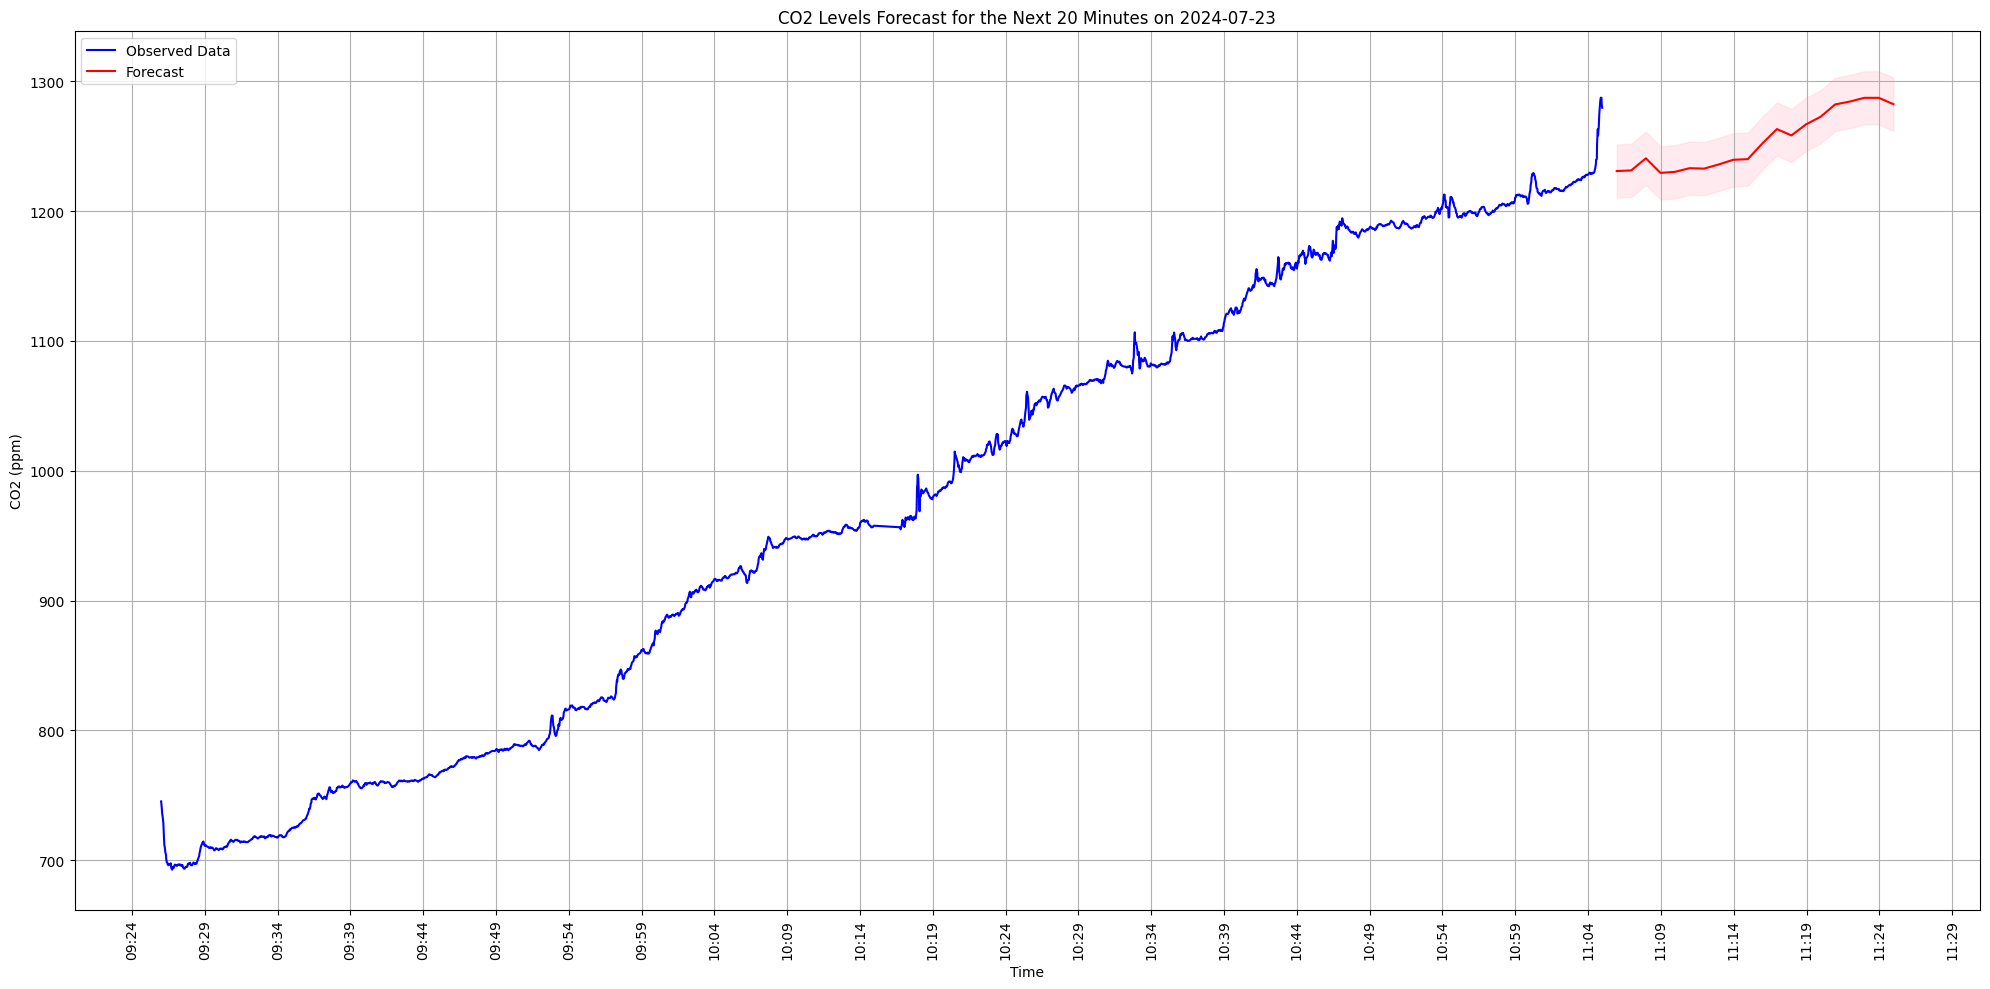

In [ ]:
#Plotting the results
plt.figure(figsize=(20, 10))
plt.plot(df_day.index, df_day['CO2 (ppm)'], label='Observed Data', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# Format x-axis to show hours
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MinuteLocator(interval=5))
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical


plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.title(f'CO2 Levels Forecast for the Next {forecast_steps} Minutes on {specific_day}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison of Actual Data vs. Forecasted Data

We load the forecast file and plot the actual CO2 data against the forecasted values for visual comparison.


**(Run this only after uploading new data to compare)**

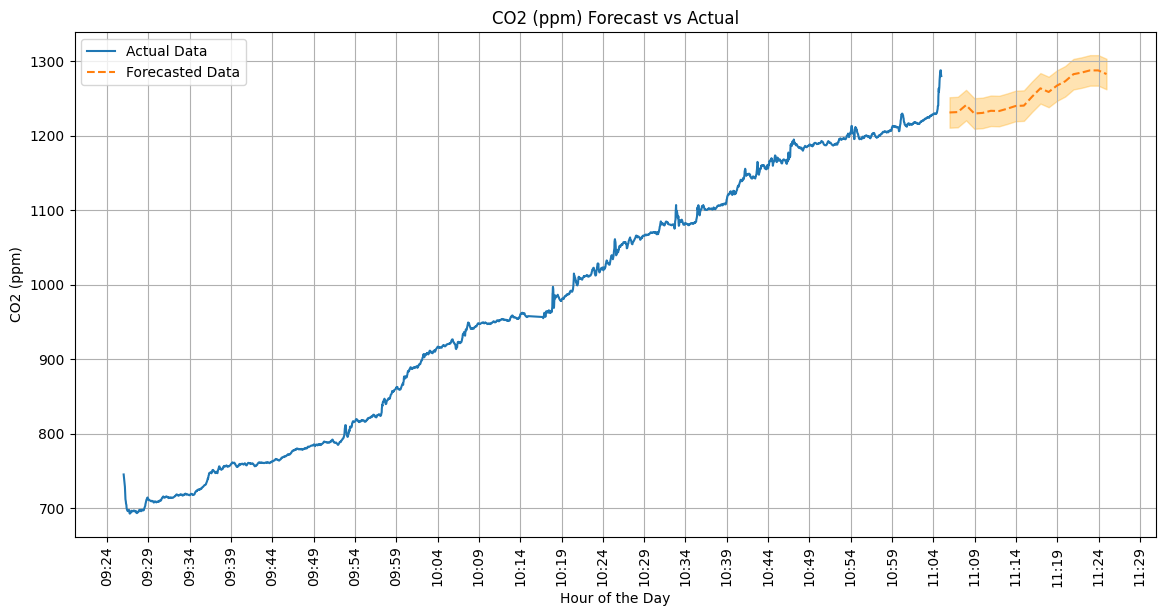

In [ ]:
# Load the combined forecast file for comparison
combined_forecast_df = pd.read_csv('forecast_predictions.csv', parse_dates=['Timestamp'])
combined_forecast_df.set_index('Timestamp', inplace=True)

# Load your dataset with the new data
df = pd.read_csv('labeled_sensor_data.csv', index_col='Timestamp', parse_dates=True)

# Ensure the index is datetime
df.index = pd.to_datetime(df.index)

# Filter data for the specific day
df_day = df[df.index.date == pd.to_datetime(specific_day).date()]

# Plot the actual data vs forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df_day.index, df_day['CO2 (ppm)'], label='Actual Data')
plt.plot(combined_forecast_df.index, combined_forecast_df['Forecast'], label='Forecasted Data', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Hour of the Day')
plt.ylabel('CO2 (ppm)')
plt.title('CO2 (ppm) Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Format x-axis to show hours
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MinuteLocator(interval=5))
plt.xticks(rotation=90)

plt.show()